<a href="https://colab.research.google.com/github/raj245rohit/cats-vs-dogs_classification/blob/main/cats_v_dogs_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Datasets

In [2]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

--2023-04-11 16:01:58--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 184.86.92.202, 2600:1417:3f:688::317f, 2600:1417:3f:69c::317f
Connecting to download.microsoft.com (download.microsoft.com)|184.86.92.202|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_5340.zip’

kagglecatsanddogs_5 100%[===================>] 786.67M  63.2MB/s    in 13s     

2023-04-11 16:02:12 (62.1 MB/s) - ‘kagglecatsanddogs_5340.zip’ saved [824887076/824887076]



In [ ]:
!unzip kagglecatsanddogs_5340.zip

Import Modules

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
from keras.utils import load_img
warnings.filterwarnings('ignore')

Create Dataframe for input and output

In [5]:
input_path = []
label = []

for class_name in os.listdir("PetImages"):
  for path in os.listdir("PetImages/"+class_name):
    if class_name == 'Cat':
      label.append(0)
    else:
      label.append(1)
    input_path.append(os.path.join("PetImages", class_name, path))
print(input_path[0], label[0])

PetImages/Dog/12173.jpg 1


In [6]:
df = pd.DataFrame()
df['images'] = input_path
df['label'] = label
df['label'] = df['label'].astype('str')
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,images,label
0,PetImages/Cat/7064.jpg,0
1,PetImages/Dog/1500.jpg,1
2,PetImages/Cat/454.jpg,0
3,PetImages/Cat/4287.jpg,0
4,PetImages/Cat/6617.jpg,0


In [7]:
df = df[df['images'].str[-4:] == '.jpg']
print(len(df))


25000


In [8]:
import PIL
for image in df['images']:
  try:
    img = PIL.Image.open(image)
  except:
    df = df[df['images'] != image]

print(len(df))


24998


Exploratory Data Analysis

In [9]:
import random
# Display grid of images
plt.figure(figsize=(25,25))
temp = df[df['label']==1]['images']
start = random.randint(0,len(temp))
files = temp[start:start+25]

for index, file in enumerate(files):
  plt.subplot(5,5,index+1)
  img = load_img(file)
  img = np.array(img)
  plt.imshow(img)
  plt.title('Dog')
  plt.axis('off')

<Figure size 2500x2500 with 0 Axes>

<Axes: ylabel='count'>

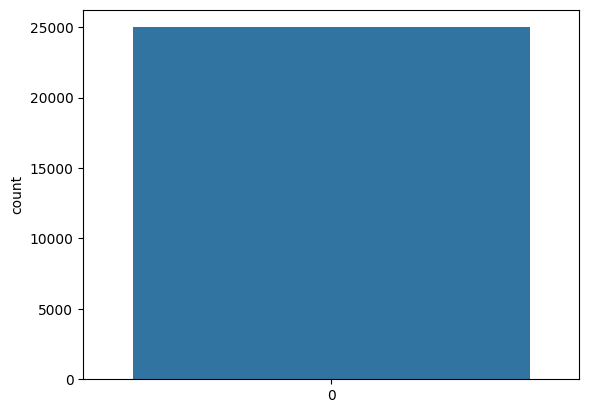

In [10]:
import seaborn as sns
sns.countplot(df['label'])

Create DataGenerator for Images

In [11]:
#input split
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [12]:
test.head()

,images,label
6869,PetImages/Cat/1975.jpg,0
22914,PetImages/Cat/5945.jpg,0
9670,PetImages/Dog/8168.jpg,1
13641,PetImages/Cat/7112.jpg,0
23341,PetImages/Dog/1449.jpg,1


In [13]:
from keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
    rescale = 1./255, #normalization of images
    rotation_range = 40,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip= True,
    fill_mode = 'nearest'
)

val_generator = ImageDataGenerator(rescale = 1./255)

train_iterator= train_generator.flow_from_dataframe(
    train,
    x_col='images', 
    y_col='label',
    target_size=(128,128),
    batch_size=512,
    class_mode='binary'
)

val_iterator = val_generator.flow_from_dataframe(
    test,
    x_col='images', 
    y_col='label',
    target_size=(128,128),
    batch_size=512,
    class_mode='binary'
)

Found 19998 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


Model Building

In [14]:
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense

In [15]:
model = Sequential([
    Conv2D(16, (3,3), activation='relu',input_shape=(128,128,3)),
    MaxPool2D((2,2)),
    Conv2D(32,(3,3),activation='relu'),
    Conv2D(64, (3,3),activation='relu'),
    MaxPool2D((2,2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
    ])

In [16]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 59, 59, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 29, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 53824)             0

In [17]:
history = model.fit(train_iterator, epochs=50, validation_data=val_iterator)

Epoch 1/50
40/40 [==============================] - 165s 4s/step - loss: 0.8630 - accuracy: 0.5242 - val_loss: 0.6618 - val_accuracy: 0.5888
Epoch 2/50
40/40 [==============================] - 147s 4s/step - loss: 0.6436 - accuracy: 0.6226 - val_loss: 0.6161 - val_accuracy: 0.6490
Epoch 3/50
40/40 [==============================] - 151s 4s/step - loss: 0.5947 - accuracy: 0.6807 - val_loss: 0.5333 - val_accuracy: 0.7270
Epoch 4/50
40/40 [==============================] - 145s 4s/step - loss: 0.5558 - accuracy: 0.7118 - val_loss: 0.5100 - val_accuracy: 0.7428
Epoch 5/50
40/40 [==============================] - 145s 4s/step - loss: 0.5355 - accuracy: 0.7255 - val_loss: 0.5053 - val_accuracy: 0.7458
Epoch 6/50
40/40 [==============================] - 148s 4s/step - loss: 0.5197 - accuracy: 0.7399 - val_loss: 0.4777 - val_accuracy: 0.7706
Epoch 7/50
40/40 [==============================] - 150s 4s/step - loss: 0.5014 - accuracy: 0.7516 - val_loss: 0.5187 - val_accuracy: 0.7340
Epoch 8/50
40

Visualization of Results

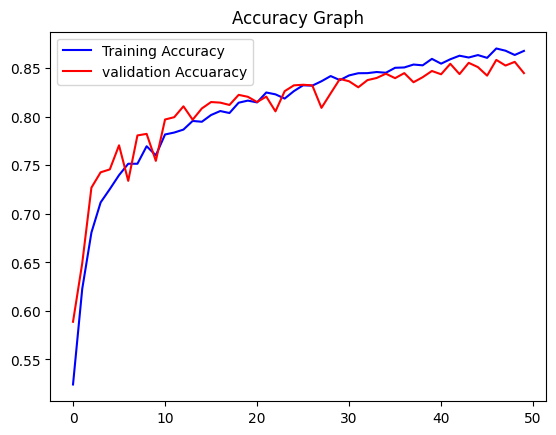

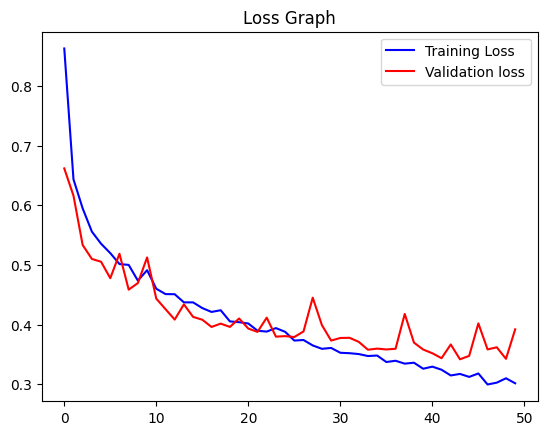

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label = 'validation Accuaracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss= history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss Graph')
plt.legend()
plt.show()